In [29]:
import pandas as pd
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import re as regex
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from pylab import rcParams
import matplotlib.pyplot as plt
import os
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
t0 = time.time()

In [2]:
# Be aware the full processing takes around 35minutes locally on 2019 13" MBP
# Speed is significantly increased when using Google Cloud Platform Custers
# But best results still happened in 10-15 minutes. 

# Import the data and start processing
url = "http://peyck.es/BDA_Project/oct18-oct19.csv"
data = pd.read_csv(url)


data['text'] = data['text'].str.replace('\\','')
data['text'] = data.iloc[:,6].str.encode('ascii', 'ignore').str.decode('unicode_escape')

In [3]:
# Uncomment and change names if working with a new dataset
columns_to_keep = ['date','text']
data = data[columns_to_keep]

# Save a local copy for more processing later
data.to_csv("data/Processed_TwitterData_oct18-oct19.csv")
datafile = 'data/Processed_TwitterData_oct18-oct19.csv'

In [5]:
# This cell is a modified version of Marcin Zablocki's Code
# Original code and a great sentiment tutorial is available here
# https://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost/


class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return
        self.data = pd.read_csv(csv_file, header=0, names=["date", "text"])
        not_null_text = 1 ^ pd.isnull(self.data["text"])
        not_null_date = 1 ^ pd.isnull(self.data["date"])
        self.data = self.data.loc[not_null_date & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None
        
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "text"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["text"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))
    
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [6]:
# Run the cell above on our full year of data
cleanText = TwitterData_Initialize()
cleanText.initialize(datafile)

In [7]:
# Checking to make sure format is correct
cleanText.processed_data.head(10)

In [10]:
# Get sentiment values 
sentiment= SentimentIntensityAnalyzer()
data['polarity_value']="Default"
data['neg']=0.0
data['pos']=0.0
data['neu']=0.0
data['compound']=0.0
for index,row in data.iterrows():
    senti = sentiment.polarity_scores(row['text'])
    data.set_value(index,'polarity_value',senti)
    data.set_value(index,'neg',senti['neg'])
    data.set_value(index,'pos',senti['pos'])
    data.set_value(index,'neu',senti['neu'])
    data.set_value(index,'compound',senti['compound'])
data.tail()

,date,text,polarity_value,neg,pos,neu,compound
4430888,3/31/19 23:59,as long as they keep getting checks from Nike!,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000,0.0000
4430889,3/31/19 23:59,NFLShop - The Official Online Shop of the NFL ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000,0.0000
4430890,3/31/19 23:59,New Uniforms are in! Thanks @Nike @ToBrad1 we ...,"{'neg': 0.0, 'neu': 0.739, 'pos': 0.261, 'comp...",0.0,0.261,0.739,0.6467
4430891,3/31/19 23:59,There's obviously a good chance that I'm going...,"{'neg': 0.0, 'neu': 0.712, 'pos': 0.288, 'comp...",0.0,0.288,0.712,0.7964
4430892,3/31/19 23:59,Check out what I just added to my closet on Po...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000,0.0000


In [11]:
# Save another local copy to avoid time delays of reprocessing
data.to_csv("data/Total_Processed_TwitterData_oct18-oct19.csv")
datafile = 'data/Total_Processed_TwitterData_oct18-oct19.csv'

In [26]:
data_scoresOnly = []
data_scoresOnly = data[['date','compound']].copy()
data_scoresOnly['date'] = pd.to_datetime(data_scoresOnly.date)
# data.to_csv("data/ScoresOnly_Processed_TwitterData_oct18-oct19.csv")
data_scoresOnly.resample('D', on='date').mean()
# data_scoresOnly.head()

,compound
date,
2018-10-01,0.120344
2018-10-02,0.121251
2018-10-03,0.094498
2018-10-04,0.075090
2018-10-05,0.013813
...,...
2019-10-27,0.129263
2019-10-28,0.124805
2019-10-29,0.141668


In [13]:
data_weekdayScores = data_scoresOnly.copy()
data_weekdayScores['weekday'] = data_weekdayScores['date'].apply(lambda x: x.weekday())
data_weekdayScores = data_weekdayScores.resample('D', on='date').mean()
# data_weekdayScores.head(10)

In [14]:
data_weekdayScores = data_weekdayScores[data_weekdayScores['weekday'] < 5]

In [15]:
data_weekdayScores = data_weekdayScores[[ 'compound']]

In [16]:
data1 = data_weekdayScores.copy()
data1.head()

,compound
date,
2018-10-01,0.120344
2018-10-02,0.121251
2018-10-03,0.094498
2018-10-04,0.075090
2018-10-05,0.013813


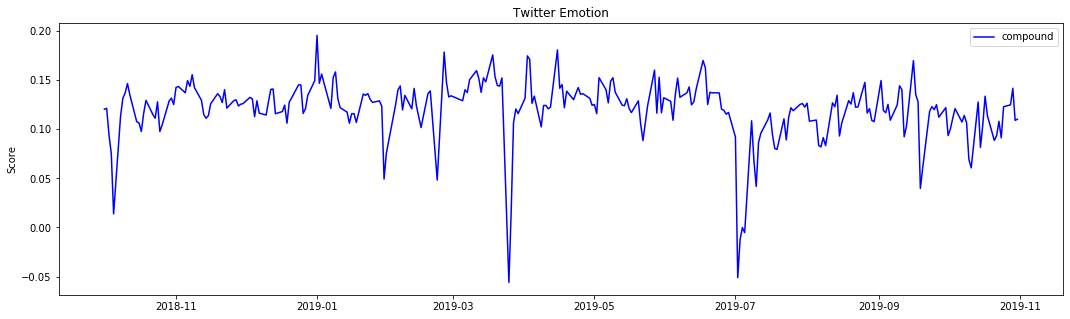

In [17]:
rcParams['figure.figsize'] = 18, 5
plt.plot(data1.index, data1['compound'], color='blue', label='compound')
# plt.plot(data1.index, data1['pos'], color='red', label='pos')
# plt.plot(data1.index, data1['neg'], color='green', label='neg')
plt.title('Twitter Emotion')
plt.ylabel('Score')
plt.legend()

# Start Finance


In [18]:
start=datetime(2018,10,1)
end=datetime(2019,10,30)
df = web.DataReader(['NKE'], 'yahoo', start, end)

In [1]:
df['datetime']=df.index
df['datetime'] = pd.to_datetime(df['datetime'])
df1=df.set_index("datetime").copy()
df1.head()
df1['date']=df['datetime'] # replace with a common name date
df1.head(100)

NameError: name 'df' is not defined

In [20]:
new_df = df1['Adj Close'].pct_change()
new_df['date']=df['datetime']
new_df.fillna(method='ffill')
new_df.head()

Symbols,NKE,date
datetime,,
2018-10-01,NaN,2018-10-01
2018-10-02,-0.020010,2018-10-02
2018-10-03,-0.003262,2018-10-03
2018-10-04,-0.028121,2018-10-04
2018-10-05,-0.000748,2018-10-05


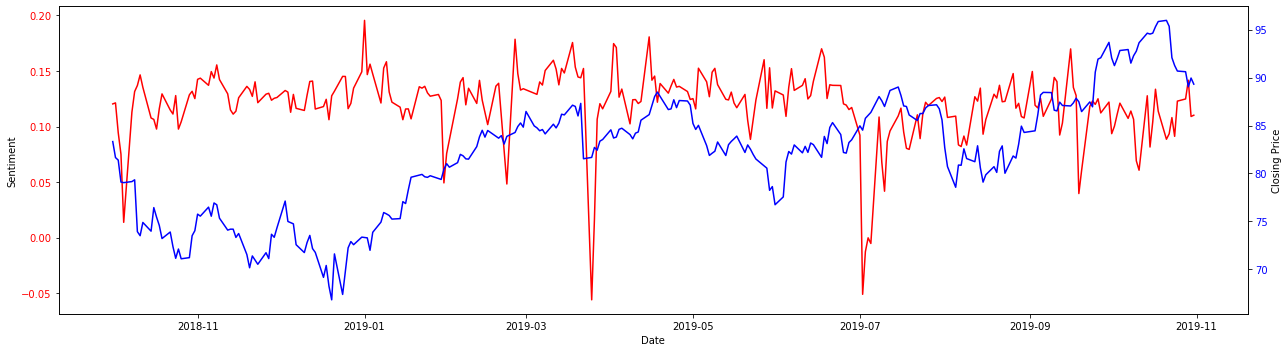

In [21]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment')
ax1.plot(data1.index, data1['compound'], color = 'r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Closing Price')
ax2.plot(df.index, df['Adj Close'], color = 'b')
ax2.tick_params(axis='y', labelcolor='b')
fig.tight_layout()
plt.show()

# Modeling

In [22]:
# To Do
# Make DF of compound scores and adjusted close (Or whatever other metrics we want to try)
# Train test split
# Start modeling where Adj Close is our target, compound is our feature


In [23]:
model_df = df1['Adj Close'].copy()
model_df['compound'] = data1['compound']
model_df = model_df.fillna(method='ffill')

In [24]:
model_df['date'] =df['datetime']
model_df.to_csv("data/Total_Finance_and_Compound_oct18-oct19.csv")
model_df.head(10)



Symbols,NKE,compound,date
datetime,,,
2018-10-01,83.327553,0.120344,2018-10-01
2018-10-02,81.660210,0.121251,2018-10-02
2018-10-03,81.393837,0.094498,2018-10-03
2018-10-04,79.104950,0.075090,2018-10-04
2018-10-05,79.045753,0.013813,2018-10-05
2018-10-08,79.154282,0.112978,2018-10-08
2018-10-09,79.341728,0.131499,2018-10-09
2018-10-10,73.935204,0.136931,2018-10-10
2018-10-11,73.510971,0.146459,2018-10-11


In [31]:
t1 = time.time()
total = t1-t0
# ~ 35 Minutes locally